In [2]:
import yfinance as yf
import seaborn as sns
import numpy as np
import scipy.optimize as sco
import pandas as pd
sns.set()

In [3]:
tickers = ['BABA', 'VIST', 'PAM', 'NVDA', 'GOOGL', 'LOMA', 'T', 'MELI', 'BRK-B']

data = yf.download(' '.join(tickers), interval='1mo')
data.info()

[*********************100%***********************]  9 of 9 completed
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 587 entries, 1984-06-25 to 2021-06-21
Data columns (total 54 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   (Adj Close, BABA)   82 non-null     float64
 1   (Adj Close, BRK-B)  302 non-null    float64
 2   (Adj Close, GOOGL)  203 non-null    float64
 3   (Adj Close, LOMA)   45 non-null     float64
 4   (Adj Close, MELI)   167 non-null    float64
 5   (Adj Close, NVDA)   270 non-null    float64
 6   (Adj Close, PAM)    141 non-null    float64
 7   (Adj Close, T)      439 non-null    float64
 8   (Adj Close, VIST)   24 non-null     float64
 9   (Close, BABA)       82 non-null     float64
 10  (Close, BRK-B)      302 non-null    float64
 11  (Close, GOOGL)      203 non-null    float64
 12  (Close, LOMA)       45 non-null     float64
 13  (Close, MELI)       167 non-null    float64
 14  (Close, NVDA)     

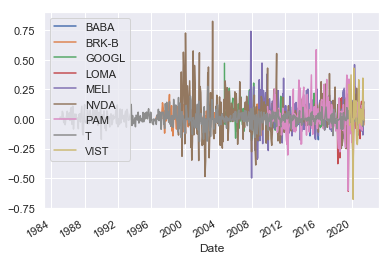

In [4]:
returns = data['Close'].pct_change()
returns.plot()

In [5]:
mean_returns = returns.mean() * 12
cov_matrix = returns.cov() * 12
risk_free_rate = 0.015

def generate_weights(nr_tickers):
    weights = np.random.random(nr_tickers)
    weights /= np.sum(weights)
    return weights

mean_returns

BABA     0.129486
BRK-B    0.091084
GOOGL    0.195399
LOMA    -0.057581
MELI     0.312784
NVDA     0.338062
PAM      0.138179
T        0.049752
VIST     0.295198
dtype: float64

In [6]:
def performance(weights, mean_returns, cov_matrix):
    expected_return = np.matmul(weights, mean_returns)
    expected_std = np.sqrt(np.dot(weights, np.dot(cov_matrix, weights)))
    sharp_ratio = (expected_return - risk_free_rate) / expected_std
    
    return expected_std, expected_return

In [7]:
# Function to optimize
def objective_func(weights, mean_returns, cov_matrix, risk_free_rate):
    std, ret = performance(weights, mean_returns, cov_matrix)
    return -((ret-risk_free_rate) / std)

In [8]:
num_assets = len(tickers)
# Min 1% of portfolio, max 50%
bound = (0.01,0.5)
bounds = tuple(bound for asset in range(num_assets))
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
args = (mean_returns, cov_matrix, risk_free_rate)
result = sco.minimize(objective_func, generate_weights(num_assets), args=args, bounds=bounds, constraints=constraints)
result.x

for i in range(0, len(tickers)):
    print('%s: %.2f' % (tickers[i], result.x[i]))
    
expected_std, expected_returns = performance(result.x, mean_returns, cov_matrix)
print('Expected returns: %.2f' % expected_returns)
print('Standard deviation: %.2f' % expected_std)

BABA: 0.01
VIST: 0.29
PAM: 0.33
NVDA: 0.01
GOOGL: 0.14
LOMA: 0.15
T: 0.04
MELI: 0.01
BRK-B: 0.01
Expected returns: 0.20
Standard deviation: 0.20


In [9]:
nr_portfolios = 1000
portfolios = []
for k in range(0,nr_portfolios):
    random_weights = generate_weights(num_assets)
    std, ret = performance(random_weights, mean_returns, cov_matrix)
    portfolios.append({'std': std, 'ret': ret, 'type': 'random'})
    
portfolios.append({'std': expected_std, 'ret': expected_returns, 'type': 'optimal'})

portfolios = pd.DataFrame(portfolios)

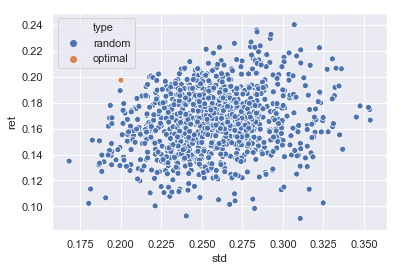

In [10]:
sns.scatterplot(data=portfolios, x='std', y='ret', hue='type')